In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
import requests
import os
import csv
import seaborn as sns
sns.set()

import warnings  
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
LABELS_TO_EXCLUDE = ['__name__', 'job', 'node']

In [3]:
def datetime_to_unix(dt):
    return time.mktime(dt.timetuple())

def query_to_csv(ts_json, csv_dir):
    """
    Save JSON with timeseries to .csv

    Parameters
    ----------
    ts_json: JSON
        JSON with timeseries metadata and values

    csv_dir: str
        Directory to save .csv files
    """

    examle_res = ts_json[0]
    name = examle_res['metric']['__name__']
    csv_colname = ['time', name]


    for k in examle_res['metric'].keys():
        if k not in LABELS_TO_EXCLUDE:
            csv_colname.append(k)
    print(csv_colname)

    
    file_name = '%s/%s.csv' % (csv_dir, name)
    open_mode = 'w'

#     if os.path.exists(file_name):
#         open_mode = 'a'

    csv_file = open(file_name, open_mode)

    writer = csv.DictWriter(csv_file, fieldnames=csv_colname) 
    if open_mode == 'w':
        writer.writeheader()

    for ts in ts_json:
        metric_info = {k : ts['metric'][k] for k in csv_colname[2:]}
        for gauge in ts['values']:
            time = datetime.fromtimestamp(gauge[0]).strftime('%d_%m_%H:%M')
            time_dict = {'time': time, name: gauge[1]}
            writer.writerow({**time_dict, **metric_info})

    csv_file.close()

In [23]:
START_TIME = '1/06/2019 12:00'
END_TIME = '30/06/2019 12:00'

dt_start = datetime.strptime(START_TIME, "%d/%m/%Y %H:%M")
dt_end = datetime.strptime(END_TIME, "%d/%m/%Y %H:%M")

query = 'http_request_duration_microseconds'
step = '4m'
ts_start = datetime_to_unix(dt_start)
ts_end = datetime_to_unix(dt_end)

In [24]:
r = requests.get('http://dashboard.stg.corp.acronis.com:9090/api/v1/query_range',
                                params={
                                    'query': query,
                                    'start': ts_start,
                                    'end': ts_end,
                                    'step': step
                                    })

res = r.json()
query_to_csv(res['data']['result'], '.')

['time', 'http_request_duration_microseconds', 'dc', 'handler', 'instance', 'quantile']


In [25]:
df = pd.read_csv('http_request_duration_microseconds.csv')

df.columns = ['time', 'http_request_duration_microseconds', 'dc', 'handler', 'instance', 'quantile']

df.head()

,time,http_request_duration_microseconds,dc,handler,instance,quantile
0,01_06_12:00,72426.569,ash1-acs1,prometheus,172.28.16.176:9100,0.5
1,01_06_12:04,69991.435,ash1-acs1,prometheus,172.28.16.176:9100,0.5
2,01_06_12:08,65432.793,ash1-acs1,prometheus,172.28.16.176:9100,0.5
3,01_06_12:12,62356.649,ash1-acs1,prometheus,172.28.16.176:9100,0.5
4,01_06_12:16,71411.531,ash1-acs1,prometheus,172.28.16.176:9100,0.5


In [ ]:
print('Len: ', df.shape[0])
df = df[df['instance'].apply(lambda elem: str(elem).endswith('-stor01.vstoragedomain'))]
print('Len: ', df.shape[0])

In [ ]:
df.drop(columns=['instance'], inplace=True)

In [ ]:
df.shape

In [ ]:
df.sort_values('time', inplace=True)

In [ ]:
for dc in df['dc'].unique():
    plt.figure(figsize=(20, 5))
    plt.title(f"dc={dc}")
    
    val = df[df['dc'] == dc]['http_request_duration_microseconds'].values
    val = val / val.max()
    diff = np.diff(val)
    plt.plot(val)
    plt.plot(diff)

# Кол-во потенциальный перезагрузок по датацентрам (посчитано на основе метрики):

* au2-acs1: 1
* eu2-acs1: 4
* eu3-acs1: 0
* eu5-acs1: 1
* eu9-acs1: 4
* jp2-acs1: 2
* nissan: 0
* ru2-acs1: 3
* us2-acs1: 2
* us3: 2
* us3-acs2: 1
* us6-acs1: 1
* us6-acs2: 0

# Черновик

In [5]:
metrics_to_compute = None

with open('../labels.txt', 'r') as f:
    metrics_to_compute = list(filter(lambda elem: elem.startswith('abgw'), f.readlines()))

In [6]:
DC_STORAGE = [
 "au2-acs1", 
 "eu2-acs1", 
 "eu3-acs1", 
 "eu5-acs1", 
 "eu9-acs1", 
 "jp2-acs1", 
 "nissan", 
 "ru2-acs1", 
 "us2-acs1", 
 "us3", 
 "us3-acs2", 
 "us6-acs1", 
 "us6-acs2", 
]


In [238]:
res['data']['result'][0]['metric']

{'__name__': 'abgw_write_reqs_total',
 'dc': 'eu9-acs1',
 'instance': 'eu9-acs1-stor01.vstoragedomain',
 'job': 'abgw',
 'node': '81204b72-8332-4d30-a01c-49a56b4c369d'}

In [244]:
LABELS_TO_EXCLUDE = ['__name__', 'job', 'node', 'dc', 'instance']
def json_to_df(ts_json):
    examle_res = ts_json[0]
    
    name = examle_res['metric']['__name__']
    for metric, val in examle_res['metric'].items():
        if metric not in LABELS_TO_EXCLUDE:
            name += f'_{metric}={val}'
                
    csv_colname = ['time', name]
    
    for k in examle_res['metric'].keys():
        if k not in LABELS_TO_EXCLUDE:
            csv_colname.append(k)
    
    rows_lst = []
    
    for ts in ts_json:
        metric_info = {k : ts['metric'][k] for k in csv_colname[2:]}
        for gauge in ts['values']:
            time = datetime.fromtimestamp(gauge[0]).strftime('%d_%m_%H:%M')
            time_dict = {'time': time, name: gauge[1]}
            
            full_row = {**time_dict, **metric_info}
            filter_row = {k: v for k, v in full_row.items() if k in csv_colname}
            
            rows_lst.append(time_dict)
        
    res = pd.DataFrame(rows_lst)
    return res

In [595]:
# def f(dc, metric_name):
#     r = requests.get('http://dashboard.stg.corp.acronis.com:9090/api/v1/query_range',
#                             params={
#                                 'query': '%s{dc="%s", instance="%s-stor01.vstoragedomain"}' % (metric_name, dc, dc),
#                                 'start': ts_start,
#                                 'end': ts_end,
#                                 'step': step
#                                 })

#     res = r.json()
#    #  print('%s{dc="%s", instance="%s-stor01.vstoragedomain"}' % (metric_name, dc_name, dc_name))
#     try:
#         df = json_to_df(res['data']['result'])
#     except:
#         df = None
#     print('l', end='')
#     return df

# def merge_save(dc_name):
#     print(dc_name)
#     res_df = f(dc_name, metrics_to_compute[0])
#     for metric_name in metrics_to_compute[1:]:
#         data = f(dc_name, metric_name)
#         if data is not None:
#             res_df = pd.merge(res_df, data, left_on='time', right_on='time')
            
    
#     print('ko')
#     res_df.to_csv(f'{dc_name}.csv')
#     print('yo')

In [401]:
# 19 24
START_TIME = '1/06/2019 12:00'
END_TIME = '30/06/2019 12:00'

dt_start = datetime.strptime(START_TIME, "%d/%m/%Y %H:%M")
dt_end = datetime.strptime(END_TIME, "%d/%m/%Y %H:%M")

query = 'abgw_iop_latency_ms_sum{dc="eu9-acs1", instance="eu9-acs1-stor01.vstoragedomain", err="OK", iop="isync", proxied="0"}'
step = '5m'
ts_start = datetime_to_unix(dt_start)
ts_end = datetime_to_unix(dt_end)

In [402]:
r = requests.get('http://dashboard.stg.corp.acronis.com:9090/api/v1/query_range',
                                params={
                                    'query': query,
                                    'start': ts_start,
                                    'end': ts_end,
                                    'step': step
                                    })

res = r.json()
query_to_csv(res['data']['result'], '.')

['time', 'abgw_iop_latency_ms_sum', 'err', 'iop', 'proxied']


In [403]:
sub_df = pd.read_csv('abgw_iop_latency_ms_sum.csv')

In [404]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 5 columns):
time                       6637 non-null object
abgw_iop_latency_ms_sum    6637 non-null float64
err                        6637 non-null object
iop                        6637 non-null object
proxied                    6637 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 259.3+ KB


In [407]:
sub_df.drop(columns=['err', 'iop', 'proxied'], inplace=True)

In [409]:
metrics_query = [
    'abgw_read_bytes_total{dc="%s", instance=~".+-stor01.vstoragedomain", proxied="0"}',
    'abgw_read_bytes_total{dc="%s", instance=~".+-stor01.vstoragedomain", proxied="1"}',
    'abgw_write_bytes_total{dc="%s", instance=~".+-stor01.vstoragedomain", proxied="0"}',
    'abgw_read_reqs_total{dc="%s", instance=~".+-stor01.vstoragedomain"}',
    'abgw_pull_progress_bytes_total{dc="%s", instance=~".+-stor01.vstoragedomain"}',
    'abgw_write_reqs_total{dc="%s", instance=~".+-stor01.vstoragedomain"}',
    
    # target
    'abgw_iop_latency_ms_sum{dc="%s", instance=~".+-stor01.vstoragedomain", err="OK", iop="isync", proxied="0"}'
]

In [410]:
feature_df = []
for query_name in metrics_query:
    
    query = query_name % 'eu9-acs1'
    
    r = requests.get('http://dashboard.stg.corp.acronis.com:9090/api/v1/query_range',
                                params={
                                    'query': query,
                                    'start': ts_start,
                                    'end': ts_end,
                                    'step': step
                                    })

    res = r.json()
    df = json_to_df(res['data']['result'])
    feature_df.append(df)

In [411]:
res_df = feature_df[0]
for iter_df in feature_df[1:]:
    res_df = pd.merge(res_df, iter_df, left_on='time', right_on='time')
res_df.set_index('time', inplace=True)

res_df.to_csv('temp.csv')

In [517]:
df = pd.read_csv('temp.csv')
target = "abgw_iop_latency_ms_sum_err=OK_iop=isync_proxied=0"

y = df[target].values.reshape(-1, 1)
X = df.drop(columns=[target, 'time']).values
stop_index = 4700


X_train, y_train =  X[stop_index:], y[stop_index:]
X_test, y_test =X[:stop_index], y[:stop_index]


In [518]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_r = sc_X.transform(X)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)
y_r = sc_y.transform(y)

In [537]:
from sklearn.linear_model import Ridge

In [589]:
model = Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [556]:
y_check.shape

(6637, 1)

In [557]:
sub_df = sub_df.reset_index()

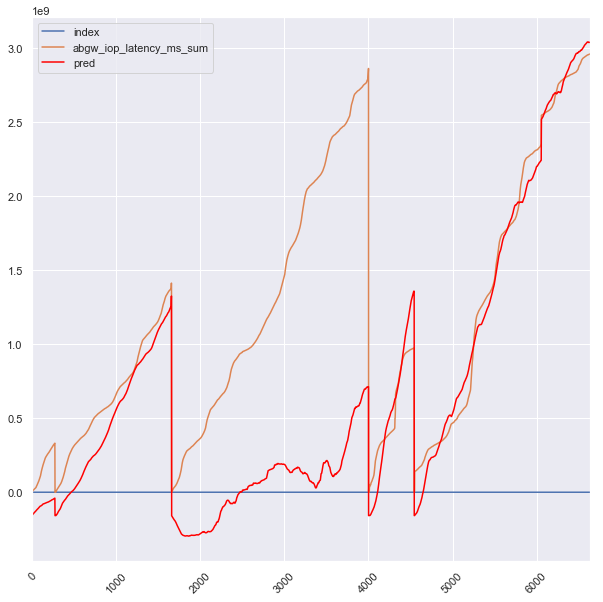

In [590]:
y_check = sc_y.inverse_transform(model.predict(sc_X.transform(X)))
sub_df.plot(figsize=(10, 10))
#  diff = np.diff(sub_df.abgw_iop_latency_ms_sum)
plt.plot(y_check, color='red', label="pred")
# plt.plot(diff, color='green', label='diff')
plt.legend()
# target_std = df[target][stop_index:].std() * 1.05
# plt.fill_between(range(len(y_check)), (y_check - target_std).reshape(-1), 
# (y_check + target_std).reshape(-1), alpha=0.3, color='red')

plt.xticks(rotation=45);

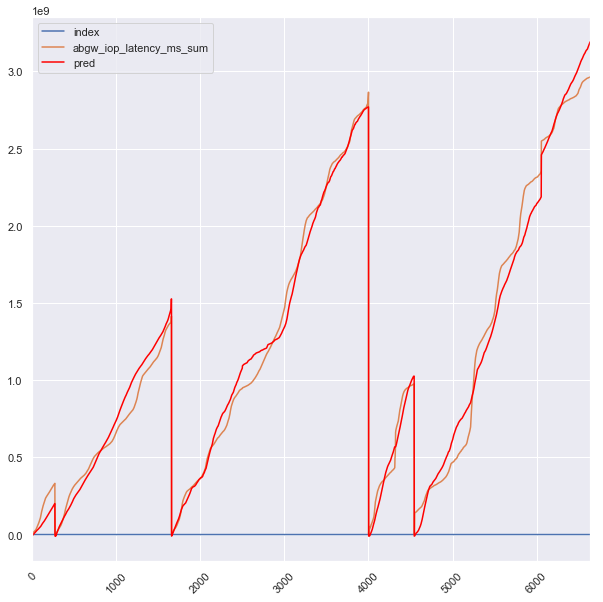

In [588]:
y_check = sc_y.inverse_transform(model.predict(sc_X.transform(X)))
sub_df.plot(figsize=(10, 10))
#  diff = np.diff(sub_df.abgw_iop_latency_ms_sum)
plt.plot(y_check, color='red', label="pred")
# plt.plot(diff, color='green', label='diff')
plt.legend()
# target_std = df[target][stop_index:].std() * 1.05
# plt.fill_between(range(len(y_check)), (y_check - target_std).reshape(-1), 
# (y_check + target_std).reshape(-1), alpha=0.3, color='red')

plt.xticks(rotation=45);

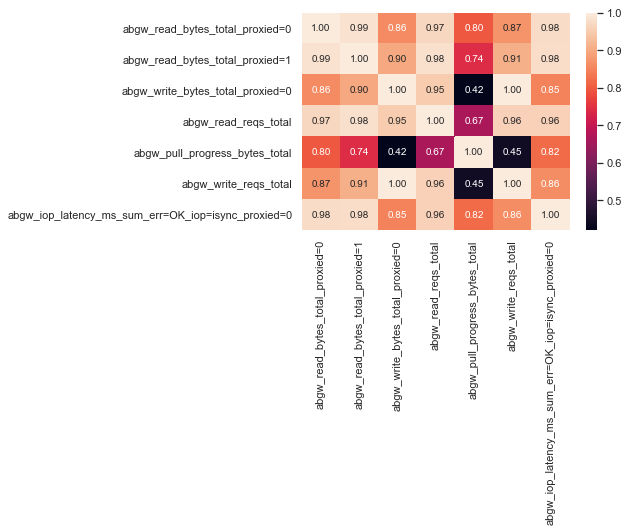

In [507]:
sns.heatmap(df.corr(), fmt='.2f', annot=True, fig);

In [591]:
best_coef = model.coef_

coed_diff = []
for win_size in [10, 20, 30]:
    coed_diff.append([])
    for ind_start in range(X.shape[0] - win_size):
        X_sample = X[ind_start: ind_start + win_size]
        y_sample = y[ind_start:  ind_start + win_size]
        
        X_sample = sc_X.transform(X_sample)
        y_sample = sc_y.transform(y_sample)
        
        model_test = Ridge()
        model_test.fit(X_sample, y_sample)
        
        coed_diff[-1].append(abs(model_test.coef_ - best_coef).sum())

In [592]:
model_test.coef_

array([[0.00035573, 0.00019106, 0.00065719, 0.0007448 , 0.00047314,
        0.00051045]])

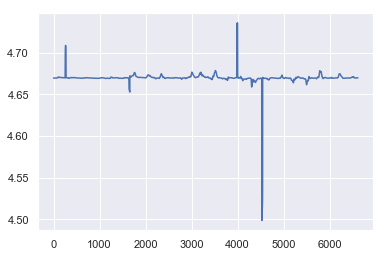

In [593]:
plt.plot(coed_diff[1])

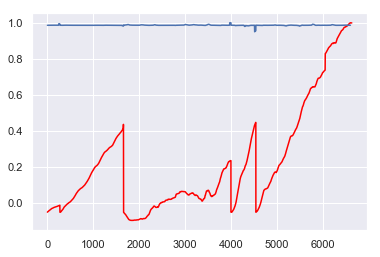

In [598]:
plt.plot(y_check  / max(y_check), color='red', label="pred")
plt.plot(coed_diff[2] / max(coed_diff[2]), label='diff')